# A.2.1 Directional semivariograms

## Table of Contents:

1. Read point data,
2. Create directional and isotropic semivariograms,
3. Compare semivariograms,
4. Compare triangular vs elliptical neighbors selection methods.

## Introduction

In this tutorial, we will learn about directional semivariograms, how to set the angle of `direction`, and the `tolerance` parameter. We compare two neighbor selection methods: **triangular**, which is fast, and **elliptical**, which is accurate.

### A directional process

Not every spatial process may be described by isotropic semivariograms. Sometimes we see a specific trend in one direction (N-S, W-E, or NE-SW, NW-SE). A well-performed analysis includes directions. That's why we will learn to write code in `pyinterpolate` that retrieves the directional semivariogram.

We use the air pollution data.

> **Note**: if you are a machine learning enthusiast, it will be easier to understand **direction** as an additional feature to model semivariance.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Experimental variogram
from pyinterpolate import build_experimental_variogram

## 1) Read and show point data

In [2]:
DATASET = 'PM2.5'

In [3]:
ds = pd.read_csv('samples/directional_variogram_PM25_20220922.csv', index_col='station_id')
ds.head()

,y,x,PM2.5
station_id,,,
659,50.529892,22.112467,7.12765
736,54.380279,18.620274,4.66432
861,54.167847,19.410942,3.00739
266,51.259431,22.569133,7.10000
355,51.856692,19.421231,2.00000


In [4]:
def df2gdf(df, lon_col='x', lat_col='y', epsg=4326, crs=None):
    """
    Function transforms DataFrame into GeoDataFrame.
    
    Parameters
    ----------
    df : pandas DataFrame
    
    lon_col : str, default = 'x'
        Longitude column name.
        
    lat_col : str, default = 'y'
        Latitude column name.
        
    epsg : Union[int, str], default = 4326
        EPSG number of projection.
        
    crs : str, default = None
        Coordinate Reference System of data.
        
    Returns
    -------
    gdf : GeoPandas GeoDataFrame
        GeoDataFrame with set geometry column ('geometry'), CRS, and all columns from the passed DataFrame.
    
    """
    
    geometry = gpd.points_from_xy(x=df[lon_col], y=df[lat_col])
    geometry.name = 'geometry'
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    
    if crs is None:
        gdf.set_crs(epsg=epsg, inplace=True)
    else:
        gdf.set_crs(crs=crs, inplace=True)
        
    return gdf

In [5]:
gds = df2gdf(ds)
gds.head()

,y,x,PM2.5,geometry
station_id,,,,
659,50.529892,22.112467,7.12765,POINT (22.11247 50.52989)
736,54.380279,18.620274,4.66432,POINT (18.62027 54.38028)
861,54.167847,19.410942,3.00739,POINT (19.41094 54.16785)
266,51.259431,22.569133,7.10000,POINT (22.56913 51.25943)
355,51.856692,19.421231,2.00000,POINT (19.42123 51.85669)


In [6]:
gds.isna().any()

y           False
x           False
PM2.5        True
geometry    False
dtype: bool

In [7]:
gds = gds.dropna(axis=0)

Text(0.5, 1.0, 'PM2.5 concentrations in Poland')

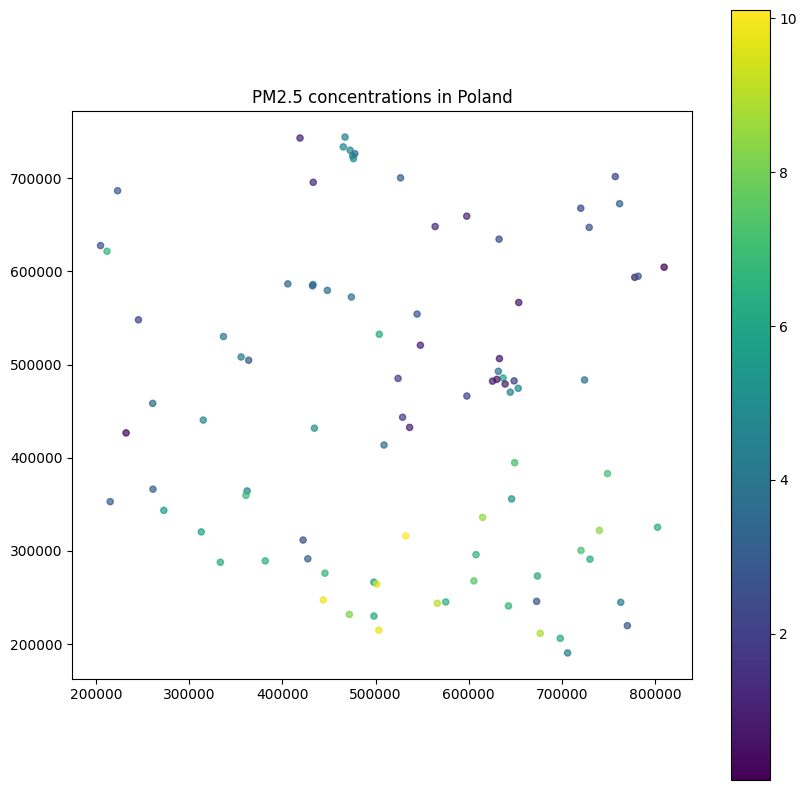

In [8]:
gds = gds.to_crs(epsg=2180)
gds.plot(figsize=(10, 10), column=DATASET, legend=True, markersize=20, alpha=0.7)
plt.title('PM2.5 concentrations in Poland')

## 2) Create the experimental semivariogram

If we recall the tutorial `A.1.1 Semivariogram Estimation`, there are three main parameters to set for the `build_experimental_variogram()` function:

1. `input_array`: `numpy array` with coordinates and observed values, for example: `[[0, 0, 10], [0, 1, 20]]`,
2. `step_size`: we must divide our analysis area into discrete **lags**. **Lags** are intervals (usually circular) within which we check if the point has a neighbor. For example, if we look into the lag `500`, then we are going to compare one point with other points in a distance `(0, 1000]` from this point,
3. `max_range`: This parameter represents the possible **maximum range of spatial dependency**. This parameter should be at most half of the extent.

But that's not everything! We didn't use three other parameters:

4. `direction`: it is a `float` in the range [0, 360]. We set the direction of the semivariogram:
  * 0 or 180: is WE direction,
  * 90 or 270 is NS direction,
  * 45 or 225 is NE-SW direction,
  * 135 or 315 is NW-SE direction.

5. `tolerance`: it is a `float` in the range [0, 1]. If we leave `tolerance` with default **1**, we will always get an isotropic semivariogram. Another edge case is if we set `tolerance` to **0**, then points must be placed on a single line with the beginning in the origin of the coordinate system and the angle given by the y-axis and direction parameter. If tolerance is > 0 and < 1, the bin is selected as an elliptical area with a major axis pointed in the same direction as the line for 0 tolerance.
  * The major axis size is `(tolerance * step_size)`,
  * The minor axis size is `((1 - tolerance) * step_size)`,
  * The baseline point is at the center of the ellipse.
  
6. `method`: it is `str` with possible values:
  - `t` or `triangle` for triangular neighbors selection which is fast and recommended for a big dataset,
  - `e` or `ellipse` for elliptical neighbors selection which is accurate but slow, recommended for small-size datasets.
  
The best idea is to visualize it on a cartesian plane:


<img src="imgs/dir_semi_tutorial_graphics.jpg" alt="The visualization of directional variogram calculation" style="max-width: 800px;"/>

* The top plane shows a unit circle that is the omnidirectional variogram (black circle). Within it, we see two ellipses: one is bright green, and another is dark green.
* The bottom plane also shows a unit circle and two ellipses: the brighter yellow, and darker purple.
* The long arrows within both circles are radiuses of the omnidirectional variogram or **the semi-major axis** of a directional ellipse. The `step_size` parameter controls its length. The short arrows are present only in the **directional variograms** and are **the semi-minor axes**. The `tolerance` parameter controls their length, and it is always:
 - a fraction of `step_size`,
 - **1**, in this case, a semivariogram is omnidirectional,
 - a value very close to 0 (but not 0) - an ellipse falls into the line.
* The good idea is to set `tolerance` to 0.5 and gradually make it smaller or larger (depending on the spatial features).

We can start the analysis by understanding how our parameters affect the semivariogram bins range. We will set `tolerance` to 0.2 in each case to better visualize the effects of a leading direction.

### Case 1: W-E Direction

In [9]:
BIN_RADIUS = 60000  # meters
MAX_RANGE = 400000  # meters
TOLERANCE = 0.2

In [10]:
inp_arr = np.array(list(zip(gds['geometry'].x,
                            gds['geometry'].y,
                            gds[DATASET])))

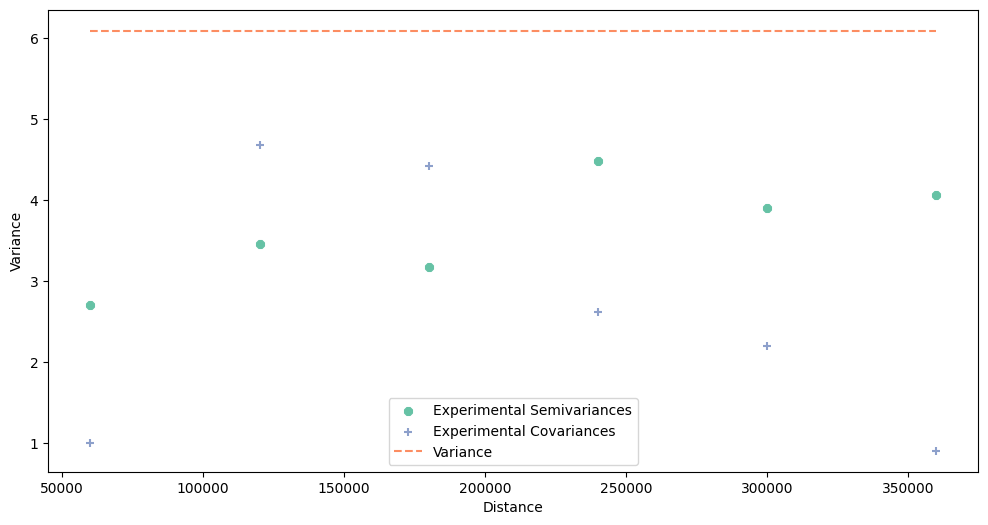

In [11]:
we_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=0,
    tolerance=TOLERANCE,
    method='e'
)

we_variogram.plot(plot_semivariance=True)

### Case 2: N-S Direction

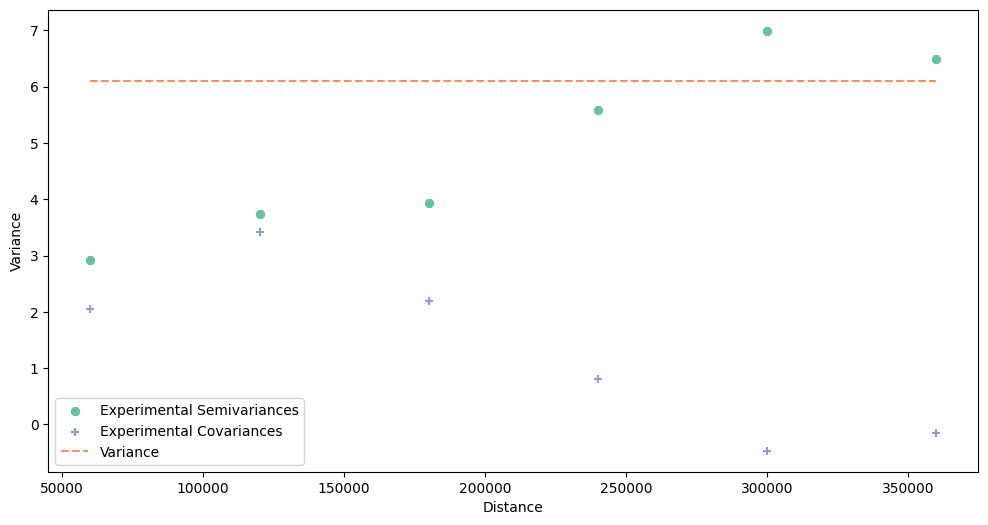

In [12]:
ns_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=90,
    tolerance=TOLERANCE,
    method='e'
)

ns_variogram.plot(plot_semivariance=True)

### Case 3: NW-SE Direction

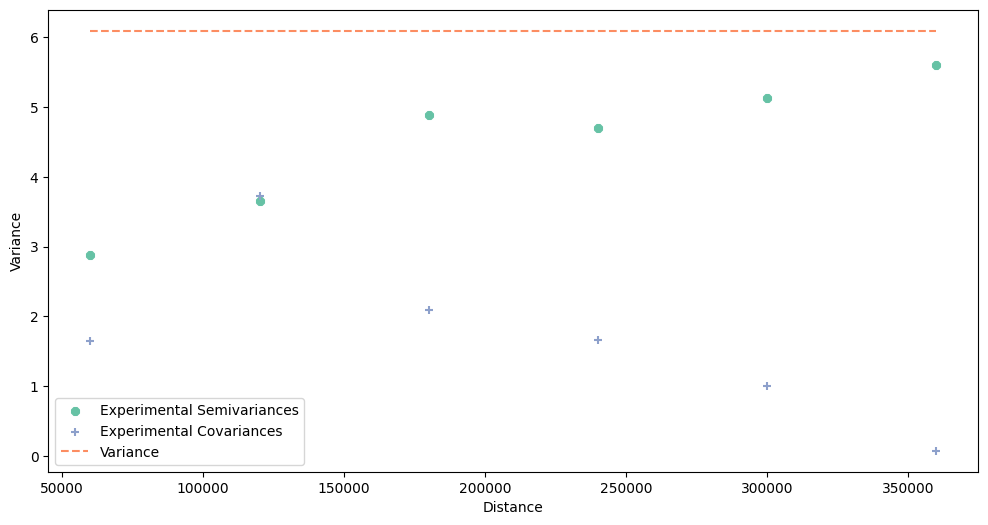

In [13]:
nw_se_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=135,
    tolerance=TOLERANCE,
    method='e'
)

nw_se_variogram.plot(plot_semivariance=True)

### Case 4: NE-SW Direction

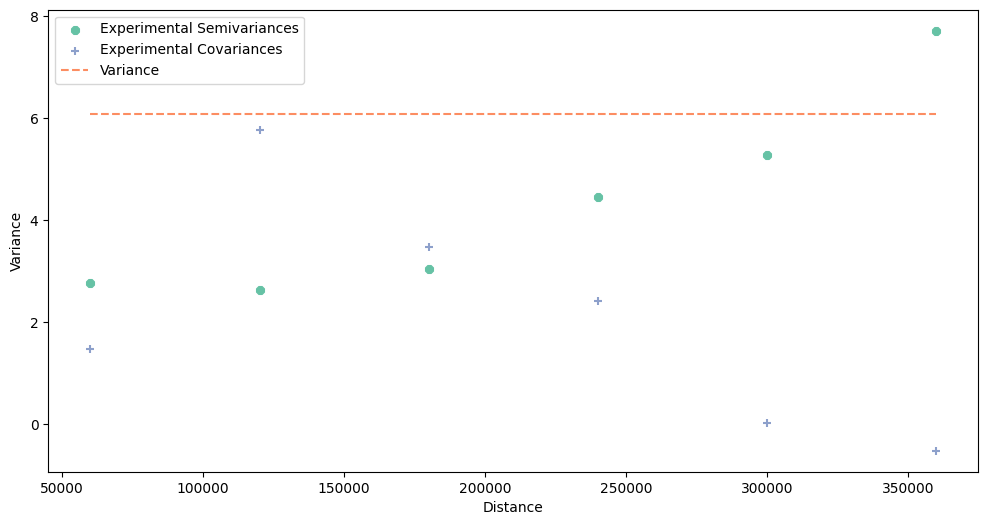

In [14]:
ne_sw_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=45,
    tolerance=TOLERANCE,
    method='e'
)

ne_sw_variogram.plot(plot_semivariance=True)

### Case 5: Isotropic Variogram

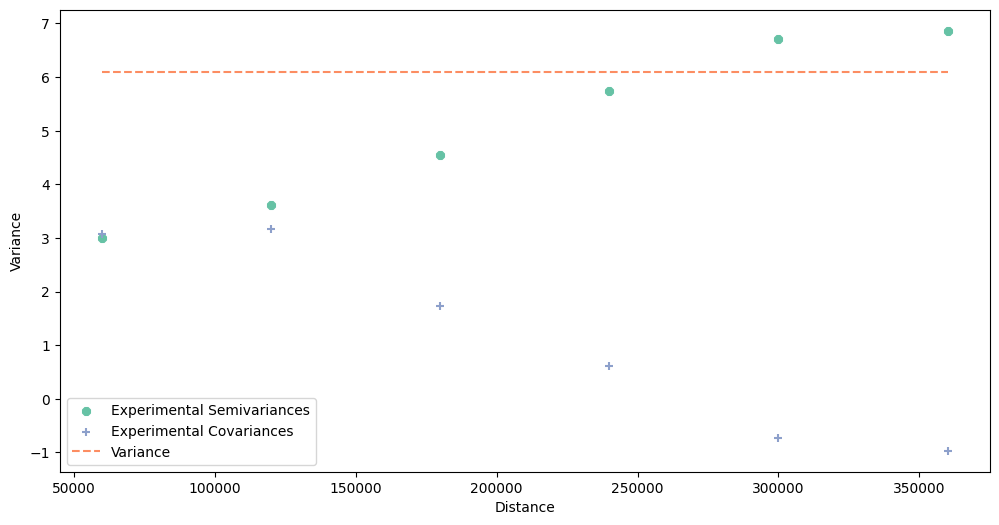

In [15]:
iso_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE
)

iso_variogram.plot()

## 3) Compare semivariograms

We have created a set of variograms. What did we observe?

- The **NE-SW** variogram is very weak at describing a short-range variation (compare it to the map of air pollution from the beginning of the tutorial. Points in this direction are relatively similar).
- The **N-S** variogram works well for a short range.
- The **W-E** variogram catches too much variability, and lags must be longer for this direction.
- The **NW-SE** variogram looks good and shows approximately linear variability change in a distance function. It has the smallest variance from all variograms.

We can visualize and compare all variograms simultaneously, and we are sure that the y-axis is the same for every plot.

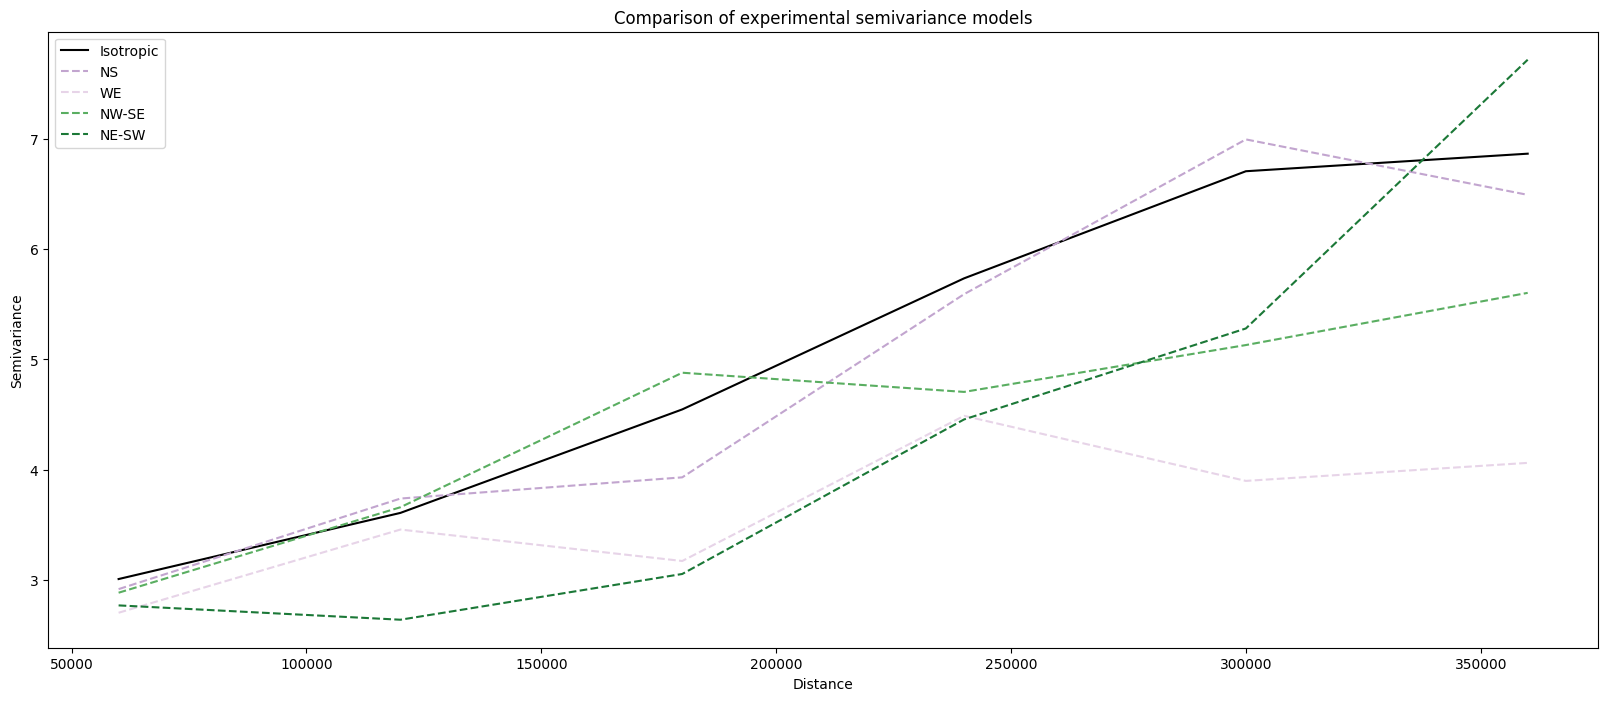

In [16]:
_lags = iso_variogram.lags
_ns = ns_variogram.experimental_semivariances
_we = we_variogram.experimental_semivariances
_nw_se = nw_se_variogram.experimental_semivariances
_ne_sw = ne_sw_variogram.experimental_semivariances
_iso = iso_variogram.experimental_semivariances

plt.figure(figsize=(20, 8))
plt.plot(_lags, _iso, color='black')
plt.plot(_lags, _ns, '--', color='#c2a5cf')
plt.plot(_lags, _we, '--', color='#e7d4e8')
plt.plot(_lags, _nw_se, '--', color='#5aae61')
plt.plot(_lags, _ne_sw, '--', color='#1b7837')
plt.title('Comparison of experimental semivariance models')
plt.legend(['Isotropic',
            'NS',
            'WE',
            'NW-SE',
            'NE-SW'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

What do you think about this comparison? Do you agree that the **NW-SE** variogram best fits the data?

## 4) Bonus: Compare calculation times and results

Let's compare calculation times and results from two methods of neighbors interpolation: `t` (triangular) and `e` (elliptical). We will follow data in the **NW-SE** direction.

In [17]:
from datetime import datetime

In [18]:
t0e = datetime.now()

# Here elliptical

nw_se_variogram_elliptical = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=135,
    tolerance=TOLERANCE,
    method='e'
)

tfin_e = (datetime.now() - t0e).total_seconds()

In [19]:
t0t = datetime.now()

# Here triangular

nw_se_variogram_triangular = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=135,
    tolerance=TOLERANCE,
    method='t'
)

tfin_t = (datetime.now() - t0t).total_seconds()

In [20]:
msg = f'The triangular method is {tfin_e / tfin_t} times faster than the elliptical selection.'

print(msg)

The triangular method is 2.4820456528664625 times faster than the elliptical selection.


For this scenario, the triangular method is 1.5x faster than the elliptical selection. However, this difference will be more significant with more points and point pairs, and triangular selection is 5x faster for big datasets.

Are variograms different? Let's compare!

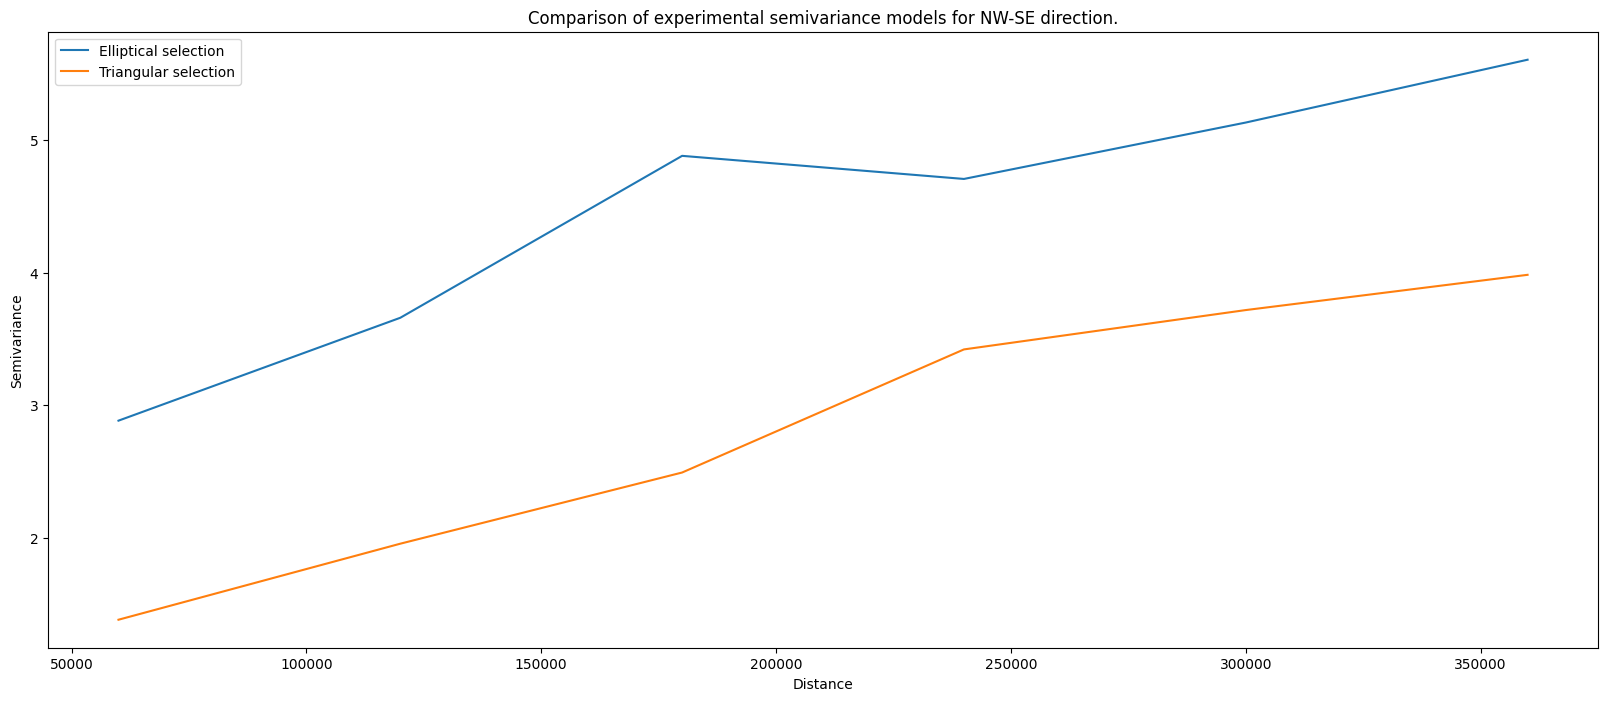

In [21]:
_lags = iso_variogram.lags
_nw_se_ell = nw_se_variogram_elliptical.experimental_semivariances
_nw_se_tri = nw_se_variogram_triangular.experimental_semivariances

plt.figure(figsize=(20, 8))
plt.plot(_lags, _nw_se_ell)
plt.plot(_lags, _nw_se_tri)
plt.title('Comparison of experimental semivariance models for NW-SE direction.')
plt.legend(['Elliptical selection', 'Triangular selection'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

The general shape is the same, but the variance of a semivariogram from a triangular selection is lower; it is harder to distinguish the covariance between neighboring points and could be dangerously close to the nugget effect. You should consider this (especially) in automatic calculations to avoid strange results or models that are not better than a simple IDW technique.

But semivariogram for the elliptical selection can have different parameters than for the triangular selection. If you choose a different step size and tolerance, the semivariogram's shape may change and could better describe dissimilarities.

---

## Where to go from here?

* A.2.2 Variogram Point Cloud
* A.2.3 Experimental Variogram and Variogram Point Cloud Classes
* B.1.1 Ordinary and Simple Kriging
* B.3.1 Directional Ordinary Kriging

## Changelog

| Date       | Change description                                                                                                                        | Author |
|------------|-------------------------------------------------------------------------------------------------------------------------------------------|--------|
| 2023-08-21 | The tutorial was refreshed and set along with the 0.5.0 version of the package  | @SimonMolinsky |
| 2023-04-15 | Update: 0.4.1 | @SimonMolinsky |
| 2023-03-04 | Removed import for the download air quality dataset                                                                                       | @SimonMolinsky |
| 2022-11-05 | Tutorial updated for the 0.3.5 version of the package                                                                                     | @SimonMolinsky |
| 2022-10-31 | Bug update: wrong direction of angle from origin, it was clockwise but now it is counterclockwise                                         | @SimonMolinsky |
| 2022-10-21 | Bug update: wrong name of the N-S variogram                                                                                               | @SimonMolinsky |
| 2022-10-17 | Bug update: directions are calculated in a valid way. New feature: added comparison between elliptical and triangular neighbors selection | @SimonMolinsky |
| 2022-09-22 | The first version of tutorial                                                                                                             | @SimonMolinsky |
